In [6]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import io
from pytorch_lightning.callbacks import Callback
from datetime import datetime, date, time
from PIL import Image
import itertools 
from sklearn.model_selection import train_test_split
import torchvision.models as models

### Device

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### Stratified train-val-test split

In [4]:
labels_map = {
    "Benign": 0,
    "InSitu": 1,
    "Invasive": 2,
}

In [5]:
with open('paths.txt', 'r') as file:
    img_paths = file.read().split('\n')
    
img_paths = np.array(img_paths)
y = []
img_labels = pd.read_csv('burnasyan_Br.csv')
for item in img_paths:
    img_folder = int(item.split("/")[1])
    label_name = img_labels.iloc[img_folder - 1][4]
    label = labels_map[label_name]
    y.append(label)
train_val_paths, test_paths, y_train_val, y_test = train_test_split(img_paths, y, test_size=0.33,
                                                     random_state=42, stratify=y)

train_paths, val_paths, y_train, y_val = train_test_split(train_val_paths, y_train_val,
                                                          test_size=0.2,random_state=42,
                                                          stratify=y_train_val)
print("Train size: ", train_paths.shape[0])
print("Val size: ", val_paths.shape[0])
print("Test size: ", test_paths.shape[0])

with open('train_paths.txt', 'w') as file:
    for i in range(train_paths.shape[0] - 1):
        file.write(train_paths[i] + '\n')  
    file.write(train_paths[train_paths.shape[0] - 1])
    
with open('val_paths.txt', 'w') as file:
    for i in range(val_paths.shape[0] - 1):
        file.write(val_paths[i] + '\n')  
    file.write(val_paths[val_paths.shape[0] - 1])
    
with open('test_paths.txt', 'w') as file:
    for i in range(test_paths.shape[0] - 1):
        file.write(test_paths[i] + '\n')  
    file.write(test_paths[test_paths.shape[0] - 1])

FileNotFoundError: [Errno 2] No such file or directory: 'burnasyan_Br.csv'

### Checking the destrinutions of splitted data

In [8]:
counts = defaultdict(int)
for l in y_train:
    counts[l] += 1 / train_paths.shape[0]

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
plt.suptitle("Train")
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

NameError: name 'y_train' is not defined

In [ ]:
counts = defaultdict(int)
for l in y_val:
    counts[l] += 1 / val_paths.shape[0]

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
plt.suptitle("Val")
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

In [ ]:
counts = defaultdict(int)
for l in y_test:
    counts[l] += 1 / test_paths.shape[0]

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
plt.suptitle("Test")
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

### Create of a dataset class

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, paths_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        f = open(paths_file, 'r')
        self.img_paths = f.read().split('\n')
        f.close()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        img_folder = int(img_path.split("/")[1])
        label_name = self.img_labels.iloc[img_folder - 1][4]
        label = torch.tensor(labels_map[label_name])
        if self.transform:
            image = image.float()
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        image = image.float()
        return image, label

## Data transformation & Train Dataset

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = ImageDataset('burnasyan_Br.csv', 'train_paths.txt', transform = transform)

In [1]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
train_features = train_features.to(device)
train_labels = train_labels.to(device)

NameError: name 'DataLoader' is not defined

## Training ResNet

In [10]:
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(512, 3)
net = net.to(device)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 3 * 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    image = Image.open(buf)
    image = image.convert("RGB")
    transform = transforms.ToTensor()
    image = transform(image)
    
    return image

def get_true_classes(input_classes):
    true_classes = []
    for i in range(len(input_classes)):
        input_classes[i] = input_classes[i].to('cpu')
        for item in input_classes[i]:
            true_classes.append(item.item()) 
    out = np.array(true_classes, dtype=np.int64)
    return out

def get_predicted_classes(input_classes):
    pred_classes = []
    for i in range(len(input_classes)):
        input_classes[i] = input_classes[i].to('cpu')
        for item in input_classes[i]:
            pred_classes.append(item.detach().numpy()) 
    pred_classes = np.array(pred_classes, dtype=object).astype(float)
    out = np.argmax(pred_classes, axis = 1)
    return out

def get_classes_probs(input_classes):
    pred_classes = []
    for i in range(len(input_classes)):
        input_classes[i] = input_classes[i].to('cpu')
        for item in input_classes[i]:
            pred_classes.append(item.detach().numpy()) 
    pred_classes = np.array(pred_classes, dtype=object).astype(float)
    return pred_classes

def log_confusion_matrix(epoch, true, pred, class_names):
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = confusion_matrix(true, pred)
    
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    writer.add_image('Confusion matrix', cm_image, epoch)
    
def log_running_loss(running_loss, epoch):
    writer.add_scalar('Training loss', running_loss / 250, epoch)
    
def log_accuracy(true, pred, epoch):
    writer.add_scalar('Accuracy', accuracy_score(true, pred), epoch)
    
def log_rocauc(true, pred, epoch):
    writer.add_scalar('ROC_AUC', roc_auc_score(true, pred,
                      multi_class='ovr', average='weighted'), epoch)
    
def log_precision(true, pred, epoch):
    writer.add_scalar('Precision', precision_score(true, pred, average='weighted'),
                      epoch)
    
def log_recall(true, pred, epoch):
    writer.add_scalar('Recall', recall_score(true, pred, average='weighted'),
                      epoch)
    
class callback(Callback):
    
    def __init__(self): 
        pass
    
    def on_epoch_begin(self, epoch):
        self.epoch = epoch
        
    def on_epoch_end(self, t, p, class_names, running_loss):
        true = get_true_classes(t)
        pred = get_predicted_classes(p)
        probs = get_classes_probs(p)
        log_confusion_matrix(self.epoch, true, pred, class_names)
        log_running_loss(running_loss, self.epoch)
        log_accuracy(true, pred, self.epoch)
        log_rocauc(true, probs, self.epoch)
        log_precision(true, pred, self.epoch)
        log_recall(true, pred, self.epoch)
        

In [25]:
logdir = "FinalTraining_logs/ResNet/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [26]:
writer = SummaryWriter(logdir)
writer.add_graph(net, train_features)

In [27]:
my_callback = callback()

In [69]:
summed = 14032 + 1358 + 26649 
weight = torch.tensor([14032, 1358, 26649]) / summed
weight = weight.pow(-1)
weight = weight.to(device)
criterion = nn.CrossEntropyLoss(weight=weight, reduction='mean')
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9)

NameError: name 'net' is not defined

In [20]:
classes = []
true_classes= []
epochs_num = 500

for epoch in tqdm_notebook(range(epochs_num), desc='epochs'):  # loop over the dataset multiple times
    
    my_callback.on_epoch_begin(epoch) 
    
    running_loss = 0.0
    i = 0
    for data in tqdm_notebook(train_dataloader, desc='one epoch training'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        true_classes.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        classes.append(nn.Softmax(dim=1)(outputs))
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i += 1
    
    my_callback.on_epoch_end(true_classes, classes,
                          ["Benign", "InSitu", "Invasive"],
                          running_loss)
    
    if epoch % 50 == 0:
        torch.save(net.state_dict(), "Saved_ResNet/")
    
    running_loss = 0.0
    classes = []
    true_classes= []

print('Finished Training')

epochs:   0%|          | 0/500 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

Finished Training


## Validation

In [10]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 3)
model = model.to(device)
model.load_state_dict(torch.load("Saved_ResNet/" + str(450)))
model.eval()
None

In [11]:
val_dataset = ImageDataset('burnasyan_Br.csv', 'val_paths.txt', transform = transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
val_features, val_labels = next(iter(val_dataloader))
val_features = val_features.to(device)
val_labels = val_labels.to(device)

In [20]:
classes = []
true_classes= []

for data in tqdm_notebook(val_dataloader, desc='validation'):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    true_classes.append(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward 
    with torch.no_grad():
        outputs = model(inputs)
    classes.append(nn.Softmax(dim=1)(outputs))
    

validation:   0%|          | 0/177 [00:00<?, ?it/s]

In [21]:
true = get_true_classes(true_classes)
pred = get_predicted_classes(classes)
probs = get_classes_probs(classes)

In [22]:
# Accuracy
print("Accuracy: ", accuracy_score(true, pred))

# Recall
print("Recall: ", recall_score(true, pred, average=None))

# Precision
print("Precision: ", precision_score(true, pred, average=None))

# ROC_AUC
print("ROC_AUC: ", roc_auc_score(true, probs, multi_class='ovr', average='weighted'))

Accuracy:  0.9597089101881434
Recall:  [0.95319149 0.75824176 0.97340426]
Precision:  [0.94514768 0.90789474 0.96960402]
ROC_AUC:  0.9933452600718803


In [26]:
true.shape

(5634,)

In [33]:
np.sum(probs.argmax(1) == true) / true.shape

array([0.95970891])

array([9.81902957e-01, 1.48731032e-02, 6.03301560e-05, ...,
       9.99979973e-01, 9.99946356e-01, 9.99328732e-01])

In [45]:
class_id = 1

roc_auc_score(true == class_id, probs[:,class_id], multi_class='ovr', average=None)

0.9952673885175719

In [48]:
true == class_id

array([False, False, False, ..., False, False, False])

In [ ]:
probs.max()

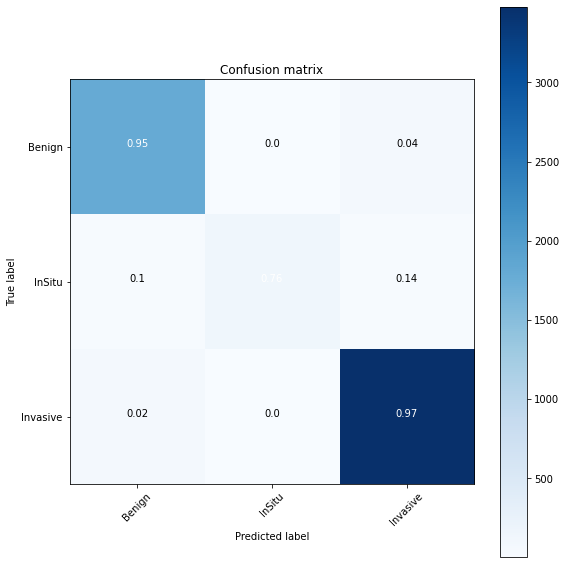

In [50]:
cm = confusion_matrix(true, pred)
figure = plot_confusion_matrix(cm, class_names=["Benign", "InSitu", "Invasive"])

In [55]:
torch.cuda.empty_cache()

# EfficientNet

In [57]:
from efficientnet_pytorch import EfficientNet
efn_model = EfficientNet.from_pretrained('efficientnet-b2', num_classes = 3).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /home/anna/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


## Training

In [60]:
logdir = "FinalTraining_logs/EfficientNet/" + datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(logdir)
writer.add_graph(efn_model, train_features)
efn_callback = callback()

In [70]:
summed = 14032 + 1358 + 26649 
weight = torch.tensor([14032, 1358, 26649]) / summed
weight = weight.pow(-1)
weight = weight.to(device)
criterion = nn.CrossEntropyLoss(weight=weight, reduction='mean')
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efn_model.parameters(), lr=1e-5, momentum=0.9)

In [75]:
classes = []
true_classes= []
epochs_num = 300

for epoch in tqdm_notebook(range(epochs_num), desc='epochs'):  # loop over the dataset multiple times
    
    efn_callback.on_epoch_begin(epoch) 
    
    running_loss = 0.0
    i = 0
    for data in tqdm_notebook(train_dataloader, desc='one epoch training'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        true_classes.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = efn_model(inputs)
        classes.append(nn.Softmax(dim=1)(outputs))
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i += 1
    
    efn_callback.on_epoch_end(true_classes, classes,
                          ["Benign", "InSitu", "Invasive"],
                          running_loss)
    
    if epoch % 50 == 0:
        torch.save(efn_model.state_dict(), "Saved_EfficientNet/" + str(epoch))
    
    running_loss = 0.0
    classes = []
    true_classes= []

print('Finished Training')

epochs:   0%|          | 0/300 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/705 [00:00<?, ?it/s]

Finished Training


## CoAtNet

In [8]:
from CoAtNet import CoAtNet
from torch.nn import functional as F

coatnet=CoAtNet(in_ch=3,image_size=224)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

coatnet.apply(init_weights)

coatnet = coatnet.to(device)

/tmp/ipykernel_13993/1781128162.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [9]:
logdir = "FinalTraining_logs/CoAtNet/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [10]:
writer = SummaryWriter(logdir)
# writer.add_graph(coatnet, train_features)

In [11]:
coat_callback = callback()

In [14]:
summed = 14032 + 1358 + 26649 
weight = torch.tensor([14032, 1358, 26649]) / summed
weight = weight.pow(-1)
weight = weight.to(device)
criterion = nn.CrossEntropyLoss(weight=weight, reduction='mean')
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(coatnet.parameters(), lr=1e-5, betas=(0.9, 0.999))

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
train_features = train_features.to(device)
train_labels = train_labels.to(device)

In [11]:
input=torch.randn(7,3,224,224).to(device)
out=coatnet(input)
print(out.shape)

torch.Size([7, 768])
torch.Size([7, 3])


one epoch training:   0%|          | 0/22532 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


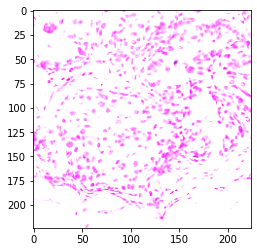

Label: input
tensor([[-0.0016, -0.0034,  0.0180]], device='cuda:0', grad_fn=<AddmmBackward>)


In [16]:
for data in tqdm_notebook(train_dataloader, desc='one epoch training'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        img = inputs.cpu().squeeze().permute(1, 2, 0).int()
        print(img.shape)
        label = "input"
        plt.imshow(img)
        plt.show()
        print(f"Label: {label}")
    
        # forward + backward + optimize
        outputs = coatnet(inputs)
        print(outputs)
        break

In [15]:
classes = []
true_classes= []
epochs_num = 500

for epoch in tqdm_notebook(range(epochs_num), desc='epochs'):  # loop over the dataset multiple times
    
    coat_callback.on_epoch_begin(epoch) 
    
    running_loss = 0.0
    i = 0
    for data in tqdm_notebook(train_dataloader, desc='one epoch training'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        true_classes.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = coatnet(inputs)
        classes.append(nn.Softmax(dim=1)(outputs))
        outputs = outputs.to(device)
#         print(outputs.shape(), labels.shape())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i += 1
    
    coat_callback.on_epoch_end(true_classes, classes,
                          ["Benign", "InSitu", "Invasive"],
                          running_loss)
    
    if epoch % 50 == 0:
        torch.save(coatnet.state_dict(), "Saved_CoAtNet/" + str(epoch))
    
    running_loss = 0.0
    classes = []
    true_classes= []

print('Finished Training')

epochs:   0%|          | 0/500 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1409 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined